In [2]:
# Shows the sweep grid
import os
import yaml
import itertools
import pandas as pd
from pathlib import Path
from dotenv import load_dotenv

load_dotenv()
BASE_DIR = Path(os.getenv("BASE_DIR"))

config_path = os.path.join(BASE_DIR, "neural_networks/configs/week5_sweep.yaml")
with open(config_path) as f:
    sweep_config = yaml.safe_load(f)
print(sweep_config)

params = sweep_config["parameters"]
param_names = list(params.keys())
values = [params[name]["values"] for name in param_names]

combinations = list(itertools.product(*values))
df = pd.DataFrame(combinations, columns=param_names)
df.head()


{'project': 'week5_sweep', 'name': 'week5_sweep', 'method': 'bayes', 'metric': {'name': 'val_wer', 'goal': 'minimize'}, 'parameters': {'learning_rate': {'values': [0.0001, 0.001, 0.0005]}, 'batch_size': {'values': [8, 16, 32, 64]}, 'hidden_dimension': {'values': [32, 64, 128, 256, 384]}, 'epochs': {'values': [5]}, 'model_type': {'values': ['rnn']}, 'full_mini': {'values': [True]}}}


,learning_rate,batch_size,hidden_dimension,epochs,model_type,full_mini
0,0.0001,8,32,5,rnn,True
1,0.0001,8,64,5,rnn,True
2,0.0001,8,128,5,rnn,True
3,0.0001,8,256,5,rnn,True
4,0.0001,8,384,5,rnn,True


In [5]:
# Loads results/week5_sweep.csv into a pandas DataFrame
import os
import pandas as pd
from dotenv import load_dotenv
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

load_dotenv()
BASE_DIR = Path(os.getenv("BASE_DIR"))

def load_results(sweep_dir):
    all_data = []
    for run_dir in os.listdir(sweep_dir):
        run_path = os.path.join(sweep_dir, run_dir)
        if not os.path.isdir(run_path):
            continue
        split_params = run_dir.split("_")
        hyperparam_vals = {}
        for param in split_params:
            if param.startswith("lr"):
                hyperparam_vals["learning_rate"] = float(param[2:])
            elif param.startswith("bs"):
                hyperparam_vals["batch_size"] = int(param[2:])
            elif param.startswith("hd"):
                hyperparam_vals["hidden_dimension"] = int(param[2:])
            elif param.startswith("run"):
                hyperparam_vals["run_id"] = str(param[3:])

        event_files = [f for f in os.listdir(run_path) if f.startswith("events.out.tfevents")]
        if not event_files:
            continue
        event_file = os.path.join(run_path, event_files[0])
        event_acc = EventAccumulator(event_file)
        try:
            event_acc.Reload()
        except Exception as e:
            print(f"Error loading {event_file}: {e}")
        
        run_data = {**hyperparam_vals, "run_dir" : run_dir}
        for tag in event_acc.Tags().get("scalars", []):
            events = event_acc.Scalars(tag)
            if events:
                run_data[tag] = events[-1].value
        all_data.append(run_data)
    df = pd.DataFrame(all_data)
    return df
sweep_csv = os.path.join(BASE_DIR, "neural_networks/results/week5_sweep.csv")
if not os.path.exists(sweep_csv):
    sweep_df = load_results(os.path.join(BASE_DIR, "neural_networks/runs/week5_sweep"))
    sweep_df.to_csv(sweep_csv, index=False)

final_df = pd.read_csv(sweep_csv)
final_df.head()

,learning_rate,batch_size,hidden_dimension,run_id,run_dir,train/ctc_loss,train/wer,val/ctc_loss,val/wer,val/cer
0,0.0001,16,256,a2oa03hq,lr0.0001_bs16_hd256_runa2oa03hq,2.793336,1.024677,2.564859,1.017581,1.017581
1,0.0005,16,128,51ckfo0h,lr0.0005_bs16_hd128_run51ckfo0h,11.244476,1.007578,11.229201,1.000000,1.000000
2,0.0001,64,32,zhpgj1y5,lr0.0001_bs64_hd32_runzhpgj1y5,11.179400,1.044607,11.445959,1.000000,1.000000
3,0.0005,16,256,26itkraj,lr0.0005_bs16_hd256_run26itkraj,2.888525,1.044365,2.729133,1.068020,1.068020
4,0.0010,64,256,saqssyo3,lr0.001_bs64_hd256_runsaqssyo3,11.254515,1.115019,11.519713,1.000000,1.000000


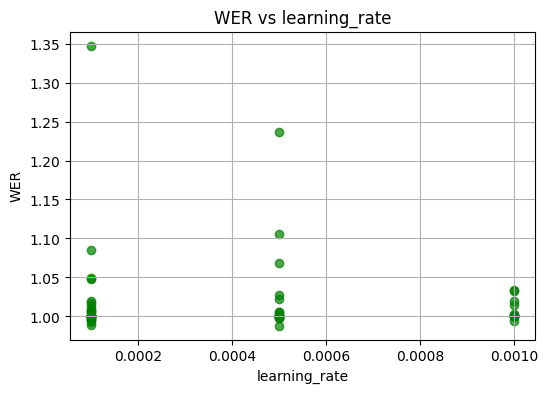

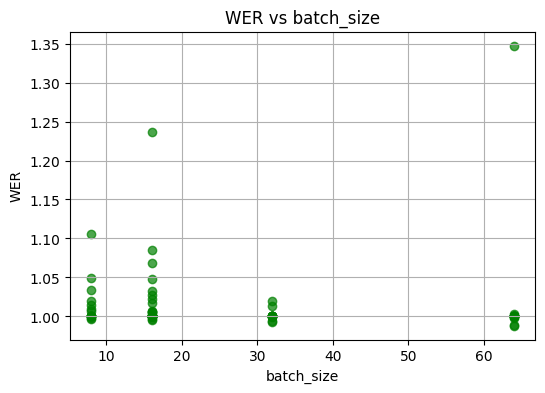

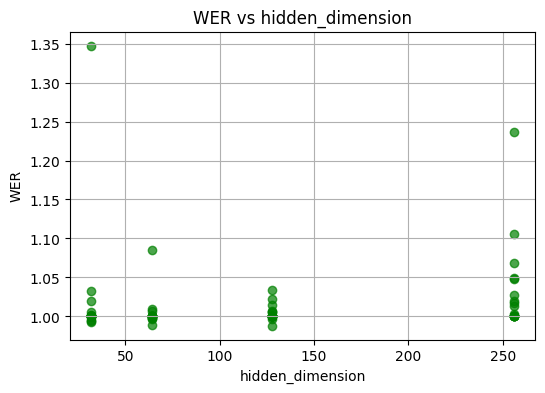

In [9]:
# Plots WER vs. each hyperparameter using matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import os
from dotenv import load_dotenv

load_dotenv()
BASE_DIR = Path(os.getenv("BASE_DIR"))

sweep_csv = os.path.join(BASE_DIR, "neural_networks/results/week5_sweep.csv")
df = pd.read_csv(sweep_csv)

hyperparams = ["learning_rate", "batch_size", "hidden_dimension"]
metric = "val/wer"

for param in hyperparams:
    plt.figure(figsize=(6,4))
    plt.scatter(df[param], df[metric], alpha=0.7, color="green")
    plt.title(f"WER vs {param}")
    plt.xlabel(param)
    plt.ylabel("WER")
    plt.grid(True)
    plt.show()

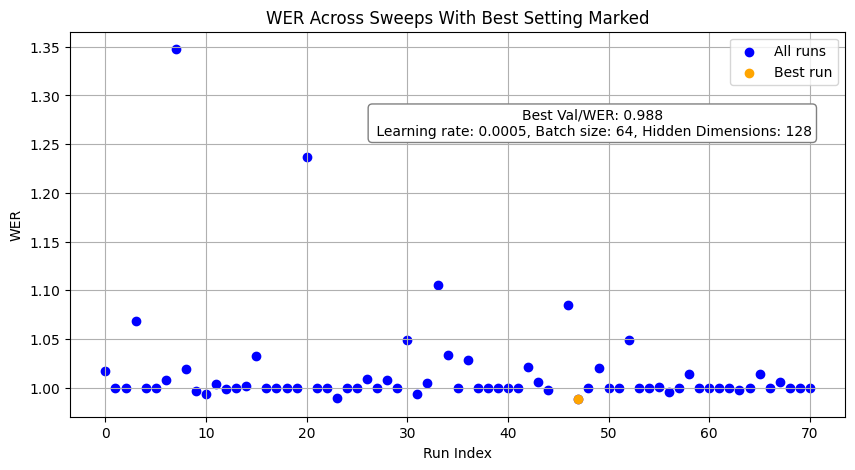

In [30]:
# Marks the best setting
import pandas as pd
import os
from dotenv import load_dotenv

load_dotenv()
BASE_DIR = Path(os.getenv("BASE_DIR"))

sweep_csv = os.path.join(BASE_DIR, "neural_networks/results/week5_sweep.csv")
df = pd.read_csv(sweep_csv)

best_idx = df["val/wer"].idxmin()
best_row = df.loc[best_idx]
best_label = (f"Best Val/WER: {best_row['val/wer']:.3f}\n Learning rate: {best_row['learning_rate']}, Batch size: {best_row['batch_size']}, Hidden Dimensions: {best_row['hidden_dimension']}")

plt.figure(figsize=(10,5))
plt.scatter(df.index, df["val/wer"], label="All runs", color = "blue")
plt.scatter(best_idx, best_row["val/wer"], label="Best run", color = "orange")
plt.annotate(best_label, (best_idx, best_row["val/wer"]), textcoords="offset points", xytext=(10,190), ha="center", bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray"))
plt.title(f"WER Across Sweeps With Best Setting Marked")
plt.xlabel("Run Index")
plt.ylabel("WER")
plt.legend()
plt.grid(True)
plt.show()
